Project to build and train a DCGAN

In [1]:
import tensorflow as tf
from tensorflow import keras
print('tensorflow version: {}'.format(tf.__version__))
print('keras version: {}'.format(keras.__version__))
print('GPU: {}'.format(tf.config.list_physical_devices('GPU')))

tensorflow version: 2.1.0
keras version: 2.2.4-tf
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np

While in this project, we ultimately wish to train the GAN on the [lfw](https://www.tensorflow.org/datasets/catalog/lfw) dataset to make it generate human faces, we will start small and train it on the Fashion-MNIST for practice. Once that works, we will try to build upon our acquired knowledge to train on the lfw dataset. 

## load the Fashion-MNIST dataset

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train, _), (_,_) = fashion_mnist.load_data()

In [4]:
print('shape of X_train: {}'.format(X_train.shape))
print('max pixel value: {}'.format(X_train.max()))
print('min pixel value: {}'.format(X_train.min()))

shape of X_train: (60000, 28, 28)
max pixel value: 255
min pixel value: 0


In [5]:
# scale the pixel value to have max = 1 and min = -1
max_px = X_train.max()
min_px = X_train.min()
A = 2/(max_px - min_px)
B = -1*(max_px + min_px)/(max_px - min_px)
X_train = A*X_train + B
print('new pixel max: {}'.format(X_train.max()))
print('new pixel min: {}'.format(X_train.min()))

new pixel max: 1.0
new pixel min: -1.0


## Build a DCGAN

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

### Generator:

In [7]:
# function to build a generator of given specifications
# Assumption: the first layer is a dense layer and 
# the rest are transpose Convolutional layers
# list layers consists of a list of tuples except for 
# the first entry which is a tuple: (num_units, activation) for the dense layer
# the second entry is tuple of two objects: the height and the width of 
# the feature maps obtained from reshaping the output of the first layer
# the rest of the enteries are tuples: (num_units, kernel_size, stride, padding, activation) for
# the transpose convolutional layers
# if batch_normalization == True, a BatchNormalization layer will be included after 
# every hidden layer except the first dense layer
# if batch_normalization == False and drop_prob!=0, then 
# a dropout layer is added after every layer except the dense layer
def build_generator(list_layers, coding_size = 100, batch_normalization = True, drop_prob = 0):
    
    dense_units, dense_act = list_layers.pop(0)
    reshape_x, reshape_y = list_layers.pop(0)
    reshape_channels = int(dense_units/(reshape_x*reshape_y))
    
    generator = Sequential()
    generator.add(Dense(units=dense_units, activation = dense_act, 
                        input_shape=[coding_size]))
    generator.add(Reshape([reshape_x, reshape_y, reshape_channels]))
    
    for layer in list_layers:
        if batch_normalization:
            generator.add(BatchNormalization())
        elif drop_prob!=0:
            generator.add(Dropout(drop_prob))
            
        num_units, kernel_size, stride, padding, activation = layer
        trans_conv = Conv2DTranspose(filters = num_units, kernel_size = kernel_size, 
                                     strides = stride, padding = padding, 
                                     activation = activation)
        generator.add(trans_conv)
        
    
    return generator

In [8]:
l1 = (7*7*128, 'selu')
l2 = (7, 7)
l3 = (64, 5, 2, 'same', 'selu')
l4 = (1, 5, 2, 'same', 'tanh')

list_layers = [l1,l2,l3,l4]
generator = build_generator(list_layers)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

### Discriminator

In [136]:
# function to build a generator with given specifications
# list_layers consists of a list of tuples used to describe each convolutional layer
# tuples: (num_units, kernel_size, stride, padding, activation)
# if batch_normalization is True, then each layer is followed by a BatchNormalization layer
# if batch_normalization is False and drop_prob!=0, then each layer is followed by a dropout layer
def build_discriminator(list_layers, input_shape, batch_normalization = False, drop_prob = 0.3):
    
    discriminator = Sequential()
    filters, kernel_size, stride, padding, activation = list_layers.pop(0) 
    conv2d = Conv2D(filters = filters, kernel_size = kernel_size, 
                    strides = stride, padding = padding, 
                    activation = activation, input_shape = input_shape)
    discriminator.add(conv2d)
    
    for filters, kernel_size, stride, padding, activation  in list_layers:
        if batch_normalization:
            discriminator.add(BatchNormalization())
        elif drop_prob!=0:
            discriminator.add(Dropout(drop_prob))
        
        conv2d = Conv2D(filters = filters, kernel_size = kernel_size, 
                    strides = stride, padding = padding, activation = activation, )
        
        discriminator.add(conv2d)
        
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation = 'sigmoid'))
        
    return discriminator

In [137]:
l1 = (64, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
l2 = (128, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
list_layers = [l1,l2]
input_shape = [28,28,1]
discriminator = build_discriminator(list_layers, input_shape)
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
_________________________________________________________________


### combine the generator and the discriminator into a GAN

In [11]:
Gan = Sequential([generator, discriminator])

In [12]:
# compiling the discriminator
loss = 'binary_crossentropy'
optimizer = 'rmsprop'
metrics = ['acc']
discriminator.compile(loss = loss, optimizer = optimizer, metrics = metrics )
discriminator.trainable = False
Gan.compile(loss = loss, optimizer = optimizer, metrics = metrics)

## Custom training loop for the GAN

In [13]:
# function to train the gan
def train_gan(gan, training_images, num_epochs = 2, batch_size = 32, coding_size = 100):
    
    generator, discriminator = gan.layers
    
    idxs = tf.range(2*batch_size)
    for epoch in tf.range(num_epochs):
        
        start = time.time()
        for true_imgs in training_images:
            
            # generate a set of random codings
            codings = tf.random.normal(shape = (batch_size, coding_size))
            # convert the codings into images
            gan_imgs = generator(codings)
            y_gan = tf.constant([[0.]]*batch_size)
            
            # mix the gan images with the true images
            y_true = tf.constant([[1.]]*batch_size)
            all_imgs = tf.concat([true_imgs, gan_imgs], axis = 0)
            all_y = tf.concat([y_true, y_gan], axis = 0)
            
            # shuffle the set of mixed images
            shuffled_idxs = tf.random.shuffle(idxs)
            shuffled_imgs = tf.gather(all_imgs, shuffled_idxs)
            shuffled_y = tf.gather(all_y, shuffled_idxs)
            
            # phase 1: train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(shuffled_imgs, shuffled_y)
        
            # phase 2: train the generator on a new set of codings
            new_codings = tf.random.normal(shape = (batch_size, coding_size))
            discriminator.trainable = False
            gan.train_on_batch(codings, 1-y_gan)
        
        end = time.time()
        time_taken = end - start
        print('\repoch:{0:}/{1:}, time:{2: .2f}s '.format(epoch+1, num_epochs, time_taken), 
              end = '', flush = True)
        print('=', end = '')

## Create a batched dataset from X_train

In [14]:
# cast the type of X_train to float32
X_train = tf.cast(X_train, tf.float32)
# Add a channel dimension to X_train
X_train = tf.reshape(X_train, [-1,28,28,1])
# create a dataset
buffer_size = 10000
batch_size = 32
training_images = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size = buffer_size)
training_images = training_images.batch(batch_size).prefetch(3)

## Train the GAN

In [15]:
num_epochs = 50
coding_size = 100
train_gan(Gan, training_images, num_epochs, batch_size, coding_size)

epoch:50/50, time: 25.22s =================================================

## Fashion-MNIST Images produced by the GAN

In [17]:
num_imgs = 32
codings = tf.random.normal(shape = [num_imgs, coding_size])
generator, _ = Gan.layers
new_imgs = generator(codings).numpy().reshape((-1,28,28))
print('shape of new_images: {}'.format(new_imgs.shape))

shape of new_images: (32, 28, 28)


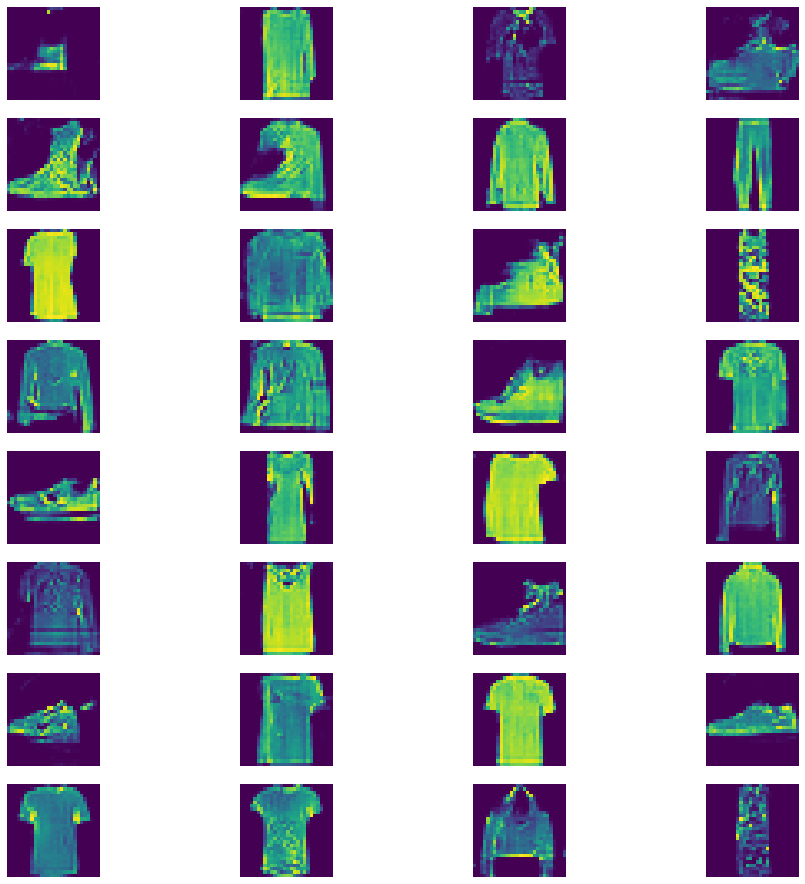

In [18]:
fig, ax = plt.subplots(figsize = (16, 16), nrows = 8, ncols = 4)
ctr = 0
for row in range(8):
    for col in range(4):
        ax[row, col].imshow(new_imgs[ctr])
        ax[row, col].axis('off')
        ctr+=1

In [19]:
# save the above output to dcgan_images directory
import os

path = os.path.join(os.getcwd(), 'dcgan_images', 'fashion_mnist.png')
print('path for fashion_mnist images: {}'.format(path))
fig.savefig(path)

path for fashion_mnist images: /home/prarit/MachineLearningProjects/DCGAN/dcgan_images/fashion_mnist.png


## LFW dataset

Having successfully trained a DCGAN on fashion-mnist dataset, let's see how it performs on the lfw dataset.

### load the LFW dataset

In [26]:
import tensorflow_datasets as tfds
# disable progress bar because otherwise, somehow,
# tfds gives me an error: FloatProgress not found. Please update jupyter and ipywidgets, 
tfds.disable_progress_bar()

In [27]:
# download using tfds.load()
# https://www.tensorflow.org/datasets/overview#tfdsload_a_dataset_in_one_line
lfw = tfds.load(name = 'lfw', split = 'train')

Shuffling and writing examples to /home/prarit/tensorflow_datasets/lfw/0.1.0.incompleteMWQ99O/lfw-train.tfrecord
Dataset lfw downloaded and prepared to /home/prarit/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [43]:
print('lfw_type: {}'.format(type(lfw)))

lfw_type: <class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


lfw as returned by tfds is a tensorflow dataset. Let's inspect an item of lfw

In [45]:
item = next(iter(lfw))
print('item_type: {}'.format(type(item)))

item_type: <class 'dict'>


We see that each item of lfw is a dictionary. It's natural to guess this consists of an image and it's label i.e. the name of the person in the image. Let's verify this. 

In [46]:
print('item_keys: {}'.format(item.keys()))

item_keys: dict_keys(['image', 'label'])


Indeed, the dictionary contains an image and its label. For our current purposes, labels are not very important and we only want the images. To do this we will have to define a preprocessing function that creates a new dataset from lfw that only consists of the images without their labels. 

In [52]:
print('shape of images in lfw: {}'.format(item['image'].shape))
print('max pix. value: {}'.format(item['image'].numpy().max()))
print('min pix. value: {}'.format(item['image'].numpy().min()))

shape of images in lfw: (250, 250, 3)
max pix. value: 255
min pix. value: 0


We will also normalize the pixel value to lie between 0 and 1

In [123]:
# function to ignore the labels and extract the images from lfw
def ignore_labels(img_dict):
    img = tf.cast(img_dict['image'], tf.float32) # must cast the pix. val to tf.float32 for multiplying an adding floats
    norm_img = tf.image.resize(img/255.0, (112,112) )
    return norm_img

In [124]:
batch_size = 32
buffer_size = 10000 
prefetch = 3
lfw_imgs = lfw.shuffle(buffer_size).batch(batch_size).map(lambda x: ignore_labels(x)).prefetch(3)

In [129]:
im=next(iter(lfw_imgs))
print('shape of im: {}'.format(im.shape))
print('max pix. val: {}'.format(tf.math.reduce_max(im)))
print('min pix. val: {}'.format(tf.math.reduce_min(im)))

shape of im: (32, 112, 112, 3)
max pix. val: 1.0
min pix. val: 0.0


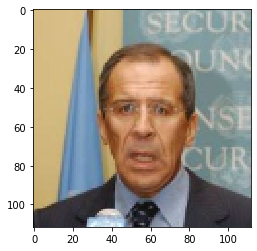

In [130]:
plt.imshow(im[0])
plt.show()

### GAN generator

We can not use the previous GAN as is, since it was designed for grayscale images. We'll keep the generator to be almost the same except that we will change the output layer to have 3 feature maps of size 112 x 112

In [133]:
coding_size = 200
l1 = (7*7*128, 'selu')
l2 = (7, 7)
l3 = (64, 5, 2, 'same', 'selu')
l4 = (64, 5, 2, 'same', 'selu')
l5 = (64, 5, 2, 'same', 'selu')
l6 = (3, 5, 2, 'same', 'sigmoid')

list_layers = [l1,l2,l3,l4,l5,l6]
generator = build_generator(list_layers, coding_size = coding_size)
generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              1260672   
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 64)       

### Gan dicriminator

In [139]:
l1 = (64, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
l2 = (64, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
l3 = (64, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
l4 = (128, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
list_layers = [l1,l2,l3,l4]
input_shape = [112,112,1]
discriminator = build_discriminator(list_layers, input_shape)
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 56, 56, 64)        1664      
_________________________________________________________________
dropout_8 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
dropout_9 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        102464    
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 128)       

### DCGAN

In [ ]:
gan = Sequential([discriminator])